In [18]:
import pandas as pd
import os
import numpy as np
from pyproj import Transformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import gc
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from haversine import haversine, Unit
from shapely.ops import unary_union
from geopy.distance import geodesic
from shapely.geometry import Point
import random
from itertools import combinations
import seaborn as sns
random.seed(42)
np.random.seed(42)

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't break lines
pd.set_option('display.max_colwidth', None) # Show full content in each cell

# Define file path
save_dir = r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
file_path = os.path.join(save_dir, 'Clustered_Data.xlsx')

# Read Excel
merged_df = pd.read_excel(file_path)

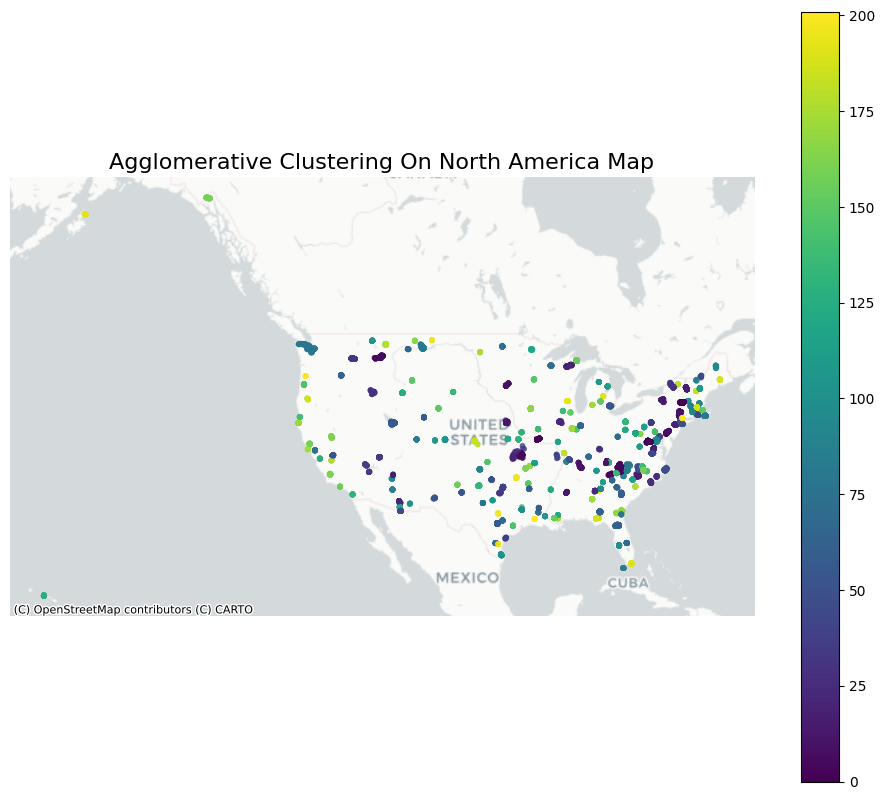

In [3]:
# Create a GeoDataFrame from your dataframe with lat/lon points
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for plotting with contextily basemap
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot colored by cluster label
gdf.plot(column='Cluster_Agglo', cmap='viridis', legend=True, markersize=10, alpha=0.7, ax=ax)

# Add basemap (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and axes off
ax.set_title('Agglomerative Clustering On North America Map', fontsize=16)
ax.set_axis_off()

plt.show()


C:\Users\sagni\AppData\Local\Temp\ipykernel_21916\202775141.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)


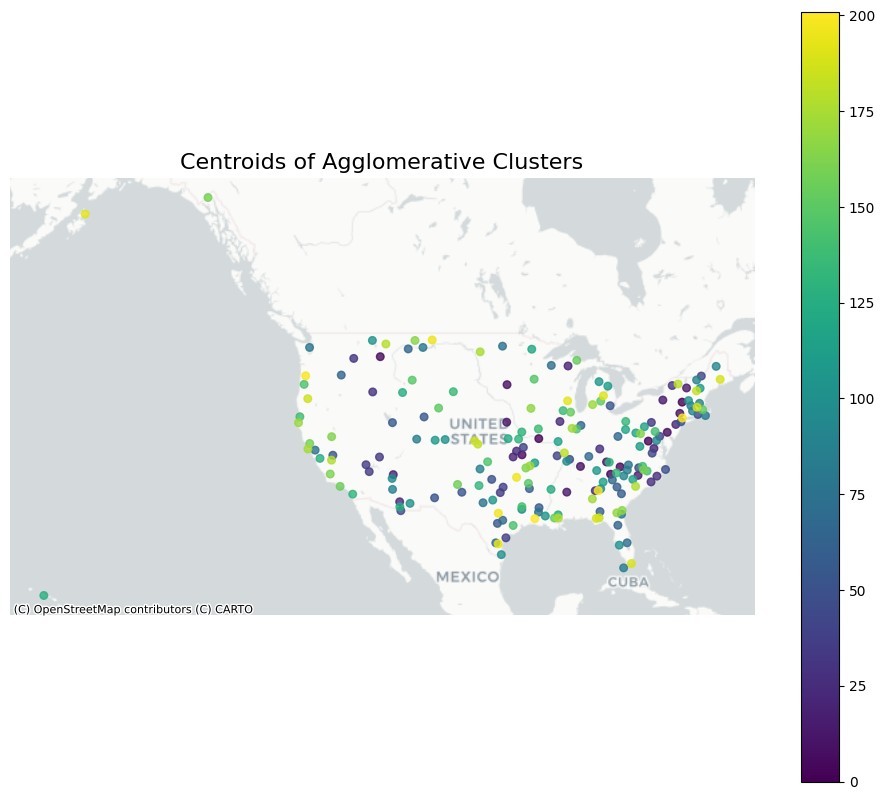

In [4]:
# Create a GeoDataFrame from your DataFrame with lat/lon points
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# Compute cluster centroids
centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)
centroids_gdf = gpd.GeoDataFrame(centroids, geometry='geometry', crs=gdf.crs).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot centroids colored by cluster
centroids_gdf.plot(column='Cluster_Agglo', cmap='viridis', legend=True, markersize=30, alpha=0.8, ax=ax)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style
ax.set_title('Centroids of Agglomerative Clusters', fontsize=16)
ax.set_axis_off()

plt.show()

C:\Users\sagni\AppData\Local\Temp\ipykernel_21916\1871321989.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)


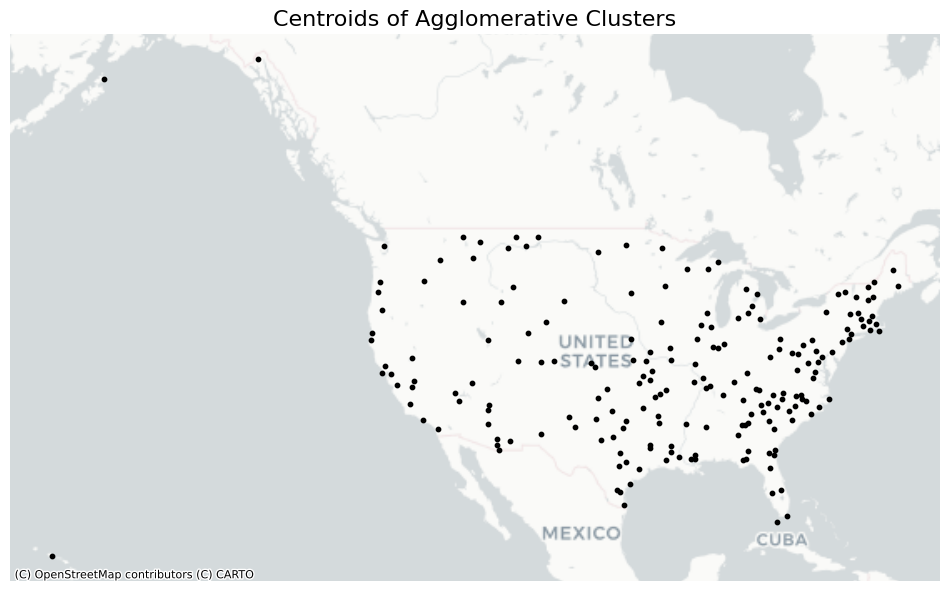

In [5]:
# Create a GeoDataFrame from your DataFrame with lat/lon points
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# Compute cluster centroids
centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)
centroids_gdf = gpd.GeoDataFrame(centroids, geometry='geometry', crs=gdf.crs).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot centroids as black dots
centroids_gdf.plot(ax=ax, color='black', markersize=10)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style
ax.set_title('Centroids of Agglomerative Clusters', fontsize=16)
ax.set_axis_off()

plt.show()


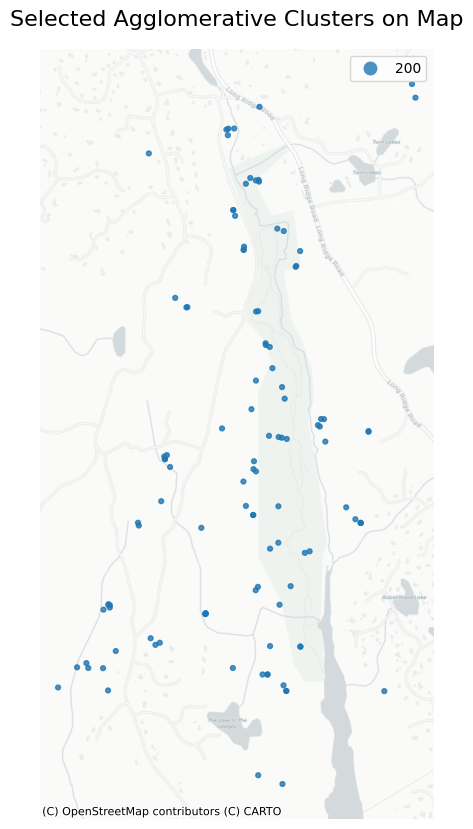

In [6]:
# List of clusters to visualize
selected_clusters = [200]

# Filter the dataframe
subset_gdf = gdf[gdf['Cluster_Agglo'].isin(selected_clusters)]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot only the selected clusters
subset_gdf.plot(column='Cluster_Agglo', categorical=True, cmap='tab10', legend=True, markersize=12, alpha=0.8, ax=ax)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and turn off axis
ax.set_title('Selected Agglomerative Clusters on Map', fontsize=16)
ax.set_axis_off()

plt.show()

In [7]:
# Step 1: Create GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

# Step 2: Count points per cluster
cluster_counts = gdf['Cluster_Agglo'].value_counts()
min_points = 5  # threshold
small_clusters = cluster_counts[cluster_counts < min_points].index.tolist()
large_clusters = cluster_counts[cluster_counts >= min_points].index.tolist()

# Step 3: Compute centroids in lat/lon space
centroids = (
    gdf.groupby('Cluster_Agglo')['geometry']
    .apply(lambda x: unary_union(x).centroid)
    .reset_index()
)
centroids.columns = ['Cluster_Agglo', 'geometry']
centroids['coords'] = centroids['geometry'].apply(lambda point: (point.y, point.x))

# Create mapping from small → nearest large
reassignment_map = {}

for small in small_clusters:
    small_coord = centroids.loc[centroids['Cluster_Agglo'] == small, 'coords'].values[0]

    # Find the nearest large cluster
    nearest_cluster = min(
        large_clusters,
        key=lambda lc: geodesic(
            small_coord,
            centroids.loc[centroids['Cluster_Agglo'] == lc, 'coords'].values[0]
        ).kilometers
    )
    reassignment_map[small] = nearest_cluster

# Step 4: Reassign small cluster points to nearest large cluster
def reassign_cluster(row):
    if row['Cluster_Agglo'] in reassignment_map:
        return reassignment_map[row['Cluster_Agglo']]
    return row['Cluster_Agglo']

gdf['Cluster_Agglo_Updated'] = gdf.apply(reassign_cluster, axis=1)

In [8]:
# Get unique updated cluster IDs and sort them
unique_clusters = sorted(gdf['Cluster_Agglo_Updated'].unique())

# Create mapping from old cluster ID → new sequential ID
new_cluster_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_clusters)}

# Apply mapping
gdf['Cluster_Agglo_Updated'] = gdf['Cluster_Agglo_Updated'].map(new_cluster_id_map)

In [1]:
# Save to Excel (drop geometry if you only want tabular data)
output_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned.xlsx"
gdf.drop(columns='geometry').to_excel(output_path, index=False)

NameError: name 'gdf' is not defined

In [10]:
#Cluster metrics
def cluster_distance_stats_df(
    df,
    cluster_col='Cluster_KMeans',
    lat_col='Latitude',
    lon_col='Longitude',
    output_dir=r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
):
    clusters = df[cluster_col].unique()
    results = []

    for c in sorted(clusters):
        cluster_points = df[df[cluster_col] == c][[lat_col, lon_col]].values
        
        count = len(cluster_points)
        if count < 2:
            results.append({
                'cluster_id': c,
                'count': count,
                'min_distance_km': np.nan,
                'avg_distance_km': np.nan,
                'max_distance_km': np.nan
            })
            continue
        
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).km
            for (lat1, lon1), (lat2, lon2) in combinations(cluster_points, 2)
        ]
        
        results.append({
            'cluster_id': c,
            'count': count,
            'min_distance_km': min(distances),
            'avg_distance_km': sum(distances) / len(distances),
            'max_distance_km': max(distances)
        })
    
    Output = pd.DataFrame(results).sort_values('cluster_id').reset_index(drop=True)
    
    # Ensure directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Full path for output file
    filename = f"{cluster_col}.xlsx"
    filepath = os.path.join(output_dir, filename)
    
    Output.to_excel(filepath, index=False)
    
    return Output

In [11]:
merged_df = gdf
del(gdf)

In [12]:
cluster_stats_df = cluster_distance_stats_df(
    merged_df, 
    cluster_col='Cluster_Agglo_Updated'
)
print(cluster_stats_df)

     cluster_id  count  min_distance_km  avg_distance_km  max_distance_km
0             0    155         0.000000        17.610304        35.409763
1             1    189         0.000000        17.236088        46.119170
2             2     67         0.000000        16.320153        33.249351
3             3     26         0.191004        17.957736        51.512177
4             4    143         0.000000        31.298508        94.704425
..          ...    ...              ...              ...              ...
193         193     12         0.200376         1.043538         3.254171
194         194      7         0.153282         0.335742         0.569034
195         195      7         0.105430         0.320037         0.675514
196         196    112         0.000000         1.495096         4.511519
197         197     11         0.002184         1.089728         2.343197

[198 rows x 5 columns]


In [13]:
print(merged_df.columns)

Index(['Deployment_ID', 'Latitude', 'Longitude', 'x', 'y', 'Cluster_KMeans',
       'Cluster_Agglo', 'Cluster_DBSCAN', 'geometry', 'Cluster_Agglo_Updated'],
      dtype='object')


C:\Users\sagni\AppData\Local\Temp\ipykernel_21916\2700169049.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroids = gdf.groupby('Cluster_Agglo_Updated')['geometry'].apply(lambda x: x.unary_union.centroid)


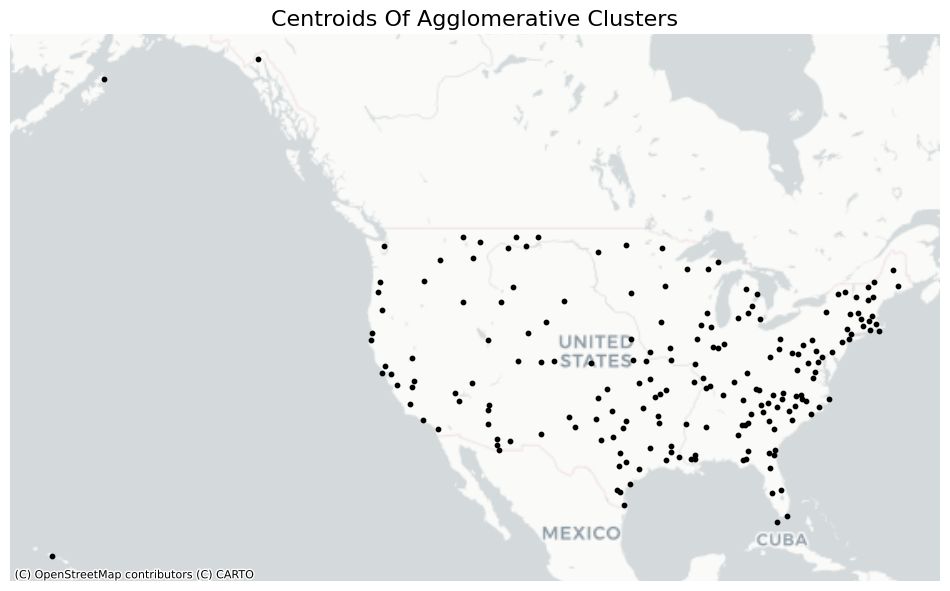

In [14]:
# Create a GeoDataFrame from your DataFrame with lat/lon points
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# Compute cluster centroids
centroids = gdf.groupby('Cluster_Agglo_Updated')['geometry'].apply(lambda x: x.unary_union.centroid)
centroids_gdf = gpd.GeoDataFrame(centroids, geometry='geometry', crs=gdf.crs).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot centroids as black dots
centroids_gdf.plot(ax=ax, color='black', markersize=10)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style
ax.set_title('Centroids Of Agglomerative Clusters', fontsize=16)
ax.set_axis_off()

#save fig
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists
fig_path = os.path.join(output_dir, "Cluster_Agglo_Centroids.png")
plt.savefig(fig_path, dpi=600, bbox_inches='tight')

plt.show()

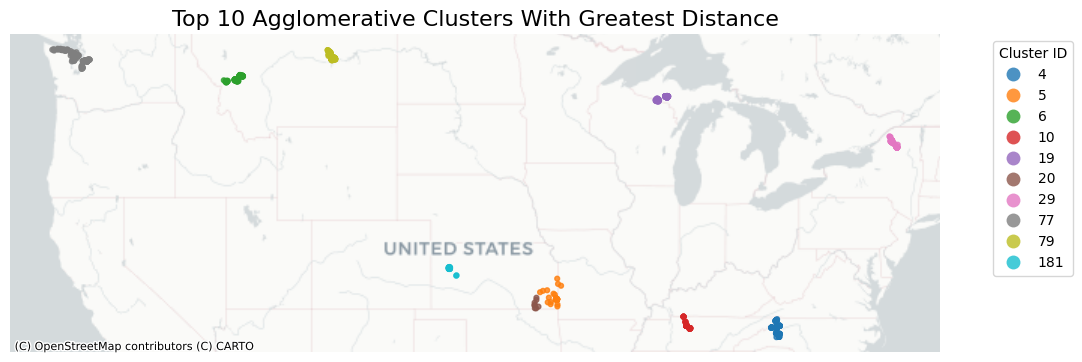

In [25]:
# List of clusters to visualize
selected_clusters = [79,	20,	181,	19,	29,	10,	6,	4,	5,	77]

# Filter the dataframe
subset_gdf = gdf[gdf['Cluster_Agglo_Updated'].isin(selected_clusters)]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot only the selected clusters
subset_gdf.plot(column='Cluster_Agglo_Updated', categorical=True, cmap='tab10', legend=True, markersize=12, alpha=0.8, ax=ax)

# Move legend to right
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((1.15, 1.0))  # x=1.15 (right), y=1.0 (top)
    leg.set_title("Cluster ID")
    leg._legend_box.align = "left"  # optional: left-align items in box

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and turn off axis
ax.set_title('Top 10 Agglomerative Clusters With Greatest Distance', fontsize=16)
ax.set_axis_off()

#save fig
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists
fig_path = os.path.join(output_dir, "Cluster_Agglo_Centroids_Top10_Distance.png")
plt.savefig(fig_path, dpi=600, bbox_inches='tight')

plt.show()

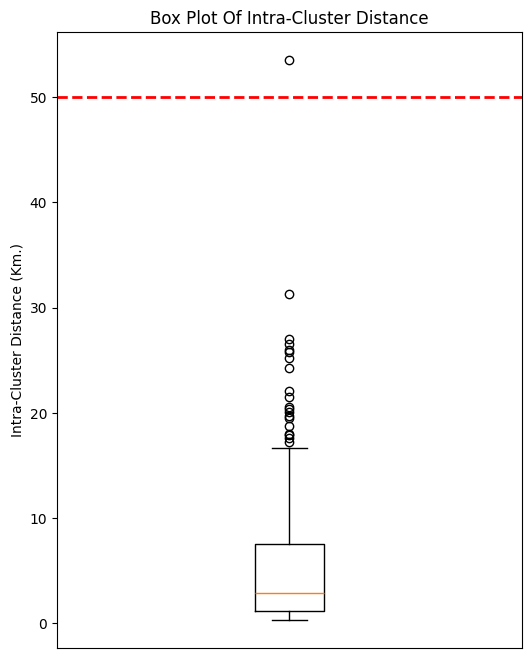

In [24]:
fig_path = os.path.join(output_dir, "BoxPlot_IntraCluster_Distance.png")

# Create figure and plot
plt.figure(figsize=(6,8))  # Taller for vertical box plot

plt.boxplot(cluster_stats_df['avg_distance_km'].dropna(), vert=True)

plt.title('Box Plot Of Intra-Cluster Distance')
plt.ylabel('Intra-Cluster Distance (Km.)')

# Remove x-axis labels/ticks
plt.xticks([])

# Add horizontal line at y=50
plt.axhline(y=50, color='red', linestyle='--', linewidth=2)

# Save the figure
plt.savefig(fig_path, dpi=600, bbox_inches='tight')

plt.show()